In [1]:
import os
import sys
import numpy as np
from scipy import sparse
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D, axes3d
import scipy.cluster.hierarchy as sch
import seaborn as sns
import spacy
import nltk
from konlpy.tag import Okt
import graphviz
from sklearn.utils.fixes import loguniform

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
from sklearn.datasets import load_files

In [4]:
reviews_train = load_files('aclImdb/train/')
text_train, y_train = reviews_train['data'], reviews_train['target']

In [5]:
text_train = [doc.replace(b'<br/>', b'') for doc in text_train]

In [6]:
np.bincount(y_train)

array([12500, 12500], dtype=int64)

In [7]:
reviews_test = load_files('aclImdb/test/')
text_test, y_test = reviews_test['data'], reviews_test['target']
text_test = [doc.replace(b'<br/>', b'') for doc in text_test]

In [8]:
bards_words = ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']

In [9]:
vect = CountVectorizer().fit(bards_words)
vect.vocabulary_

{'the': 9,
 'fool': 3,
 'doth': 2,
 'think': 10,
 'he': 4,
 'is': 6,
 'wise': 12,
 'but': 1,
 'man': 8,
 'knows': 7,
 'himself': 5,
 'to': 11,
 'be': 0}

In [10]:
bag_of_words = vect.transform(bards_words)
bag_of_words.toarray()

array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]], dtype=int64)

In [11]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [12]:
vect.get_feature_names_out()

array(['00', '000', '0000000000001', ..., 'østbye', 'über', 'üvegtigris'],
      dtype=object)

In [13]:
[text_train[i] for i in np.argwhere(X_train[:, 9] == 1)[:, 0]][0]

b'"Dutch Schultz", AKA Arthur Fleggenheimer, was a real person and his rather nasty life is fairly well documented. This movie which purports to depict his life should have used a fictional character, because the overdramatized events are too strong a departure from the facts and the chronology. Not only that, it ignores some interesting details which other versions have included such as the public relations fiasco in upstate N.Y. and his religious conversion. It is true that he was executed by Luciano, Lansky, et. al. but that\'s as far as it goes. The exploding plate scene which represents Luciano carrying out the execution of Bo Weinberg in his own home, assisted by his own mother is rediculous. Also, there is the scene in which Dutch approaches his own mother to pay protection to Legs Diamond. It just doesn\'t work. The character of Mrs. Fleggenheimer doesn\'t work either. This movie does not need a doting Jewish mother for comic relief. The lame representation of Legs Diamond was 

In [14]:
# X_train[:, 9] == 1이 (-1, 1) 형태의 shape이기에 argwhere가 [n, 0] 형태로 나타남
np.argwhere(X_train[:, 9] == 1)

array([[  554,     0],
       [ 6583,     0],
       [ 7758,     0],
       [ 9637,     0],
       [10764,     0],
       [15068,     0],
       [16627,     0],
       [17873,     0],
       [22458,     0],
       [23321,     0],
       [23473,     0]])

In [15]:
logreg = LogisticRegression(C=0.1, max_iter=5000).fit(X_train, y_train)
logreg.score(X_test, y_test)

0.87912

In [16]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [17]:
logreg = LogisticRegression(C=0.1, max_iter=5000).fit(X_train, y_train)
logreg.score(X_test, y_test)

0.87848

In [18]:
vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [19]:
logreg = LogisticRegression(C=0.1, max_iter=5000).fit(X_train, y_train)
logreg.score(X_test, y_test)

0.87332

In [20]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(C=0.1, max_iter=5000)).fit(text_train, y_train)
pipe.score(text_test, y_test)

0.85184

In [21]:
vect = pipe.named_steps['tfidfvectorizer']
feature_names = vect.get_feature_names_out()
feature_names

array(['00', '000', '007', ..., 'zuniga', 'zwick', 'émigré'], dtype=object)

In [22]:
feature_names[np.argsort(vect.idf_)[:10]]

array(['the', 'and', 'of', 'to', 'this', 'is', 'it', 'in', 'that', 'but'],
      dtype=object)

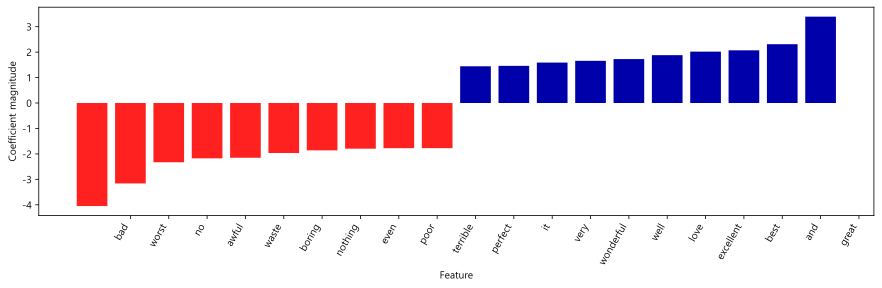

In [23]:
mglearn.tools.visualize_coefficients(pipe.named_steps['logisticregression'].coef_[0], feature_names, n_top_features=10)

In [24]:
vect = CountVectorizer(ngram_range=(1, 2)).fit(bards_words)
vect.transform(bards_words)

<2x27 sparse matrix of type '<class 'numpy.int64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [25]:
vect.get_feature_names_out()

array(['be', 'be fool', 'but', 'but the', 'doth', 'doth think', 'fool',
       'fool doth', 'he', 'he is', 'himself', 'himself to', 'is',
       'is wise', 'knows', 'knows himself', 'man', 'man knows', 'the',
       'the fool', 'the wise', 'think', 'think he', 'to', 'to be', 'wise',
       'wise man'], dtype=object)

In [26]:
pd.DataFrame(vect.transform(bards_words).toarray(), columns=vect.get_feature_names_out()).T.head()

,0,1
be,0,1
be fool,0,1
but,0,1
but the,0,1
doth,1,0


In [27]:
vect = CountVectorizer(min_df=5, ngram_range=(1, 2)).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [28]:
logreg = LogisticRegression(C=100, max_iter=5000).fit(X_train, y_train)
logreg.score(X_test, y_test)

0.89

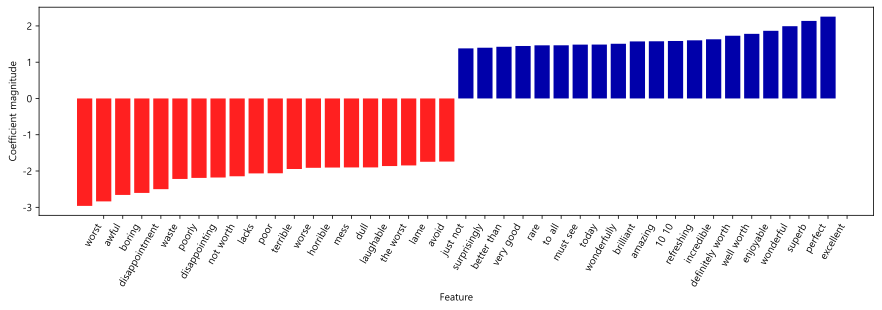

In [29]:
mglearn.tools.visualize_coefficients(logreg.coef_[0], vect.get_feature_names_out(), n_top_features=20)

In [30]:
en_nlp = spacy.load('en_core_web_sm')

In [31]:
def word_normalization(doc):
    doc_spacy = en_nlp(doc)
    print([token.lemma_ for token in doc_spacy])

In [32]:
# Dunning-Kruger Effect
bards_words_2 = 'The fool doth think he is wise, but the wise man knows himself to be a fool'
word_normalization(bards_words_2)

['the', 'fool', 'doth', 'think', 'he', 'be', 'wise', ',', 'but', 'the', 'wise', 'man', 'know', 'himself', 'to', 'be', 'a', 'fool']


In [33]:
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def custom_tokenizer(doc):
    doc_spacy = en_nlp(doc)
    return [token.lemma_ for token in doc_spacy]

In [34]:
lemma_vect = CountVectorizer(min_df=5, tokenizer=custom_tokenizer).fit(text_train)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
X_train_lemma = lemma_vect.transform(text_train)
X_test_lemma = lemma_vect.transform(text_test)

In [36]:
logreg = LogisticRegression(C=0.1).fit(X_train_lemma, y_train)
logreg.score(X_test_lemma, y_test)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.87832

In [37]:
df_train = pd.read_csv('naver/ratings_train.txt', delimiter='\t', keep_default_na=False)
df_test = pd.read_csv('naver/ratings_test.txt', delimiter='\t', keep_default_na=False)
df_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [38]:
text_train, y_train = df_train['document'].values, df_train['label'].values
text_test, y_test = df_test['document'].values, df_test['label'].values

In [39]:
np.bincount(y_train), np.bincount(y_test)

(array([75173, 74827], dtype=int64), array([24827, 25173], dtype=int64))

In [40]:
class PicklableOkt(Okt):
    def __init__(self, *args):
        self.args = args
        Okt.__init__(self, *args)
    def __setstate__(self, state):
        self.__init__(*state['args'])
    def __getstate__(self):
        return {'args':self.args}
okt = PicklableOkt()

In [41]:
vect = TfidfVectorizer(min_df=3, tokenizer=okt.morphs, ngram_range=(1, 2)).fit(text_train[:10000])
X_train = vect.transform(text_train[:10000])
X_test = vect.transform(text_test[:10000])

c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [42]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3).fit(X_train, y_train[:10000])
rf_clf.score(X_test, y_test[:10000])

0.7129

In [47]:
ko_nlp = spacy.load('ko_core_news_sm')
def ko_custom_vect(doc):
    doc_spacy = ko_nlp(doc)
    return [token.lemma_ for token in doc_spacy]

In [48]:
vect = CountVectorizer(min_df=3, tokenizer=ko_custom_vect, ngram_range=(1, 2)).fit(text_train[:10000])
X_train = vect.transform(text_train[:10000])
X_test = vect.transform(text_test[:10000])

c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [49]:
# konlpy가 훨씬 더 score가 높게 나오는듯
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3).fit(X_train, y_train[:10000])
rf_clf.score(X_test, y_test[:10000])

0.6355

In [50]:
ex_sentence = '먼저 통화지급의 원칙은 임금이 현물로 지급되는 현물급여제의 폐해를 제거하기 위하여 제정되었다. 현물로 급여를 지급하게 되면 그 가격이 불안정하고, 또 그 현물을 다시 현금으로 바꿔야하는 불편함이 존재하기 때문이다. 여기서 통화란 국내에서 강제통용력이 있는 화폐를 의미한다. 다만, 법령이나 단체협약에 의해 임금의 일부를 통화 이외의 것으로 지급할 수 있는 예외를 둔 경우에는 그에 따른다.'

In [51]:
ko_custom_vect(ex_sentence)

['먼저',
 '통화지+급+의',
 '원칙+은',
 '임금+이',
 '현물+로',
 '지급+되+는',
 '현물급여+제의',
 '폐해+를',
 '제거+하+기',
 '위하+어',
 '제정+되+었+다',
 '.',
 '현물로',
 '급여+를',
 '지급+하+게',
 '되+면',
 '그',
 '가격+이',
 '불안정+하+고',
 ',',
 '또',
 '그',
 '현물+을',
 '다시',
 '현금+으로',
 '바꿔야하+는',
 '불편함+이',
 '존재+하+기',
 '때문+이+다',
 '.',
 '여기+서',
 '통화+란',
 '국내+에서',
 '강제통용+력+이',
 '있+는',
 '화폐+를',
 '의미+하+ㄴ다',
 '.',
 '다만',
 ',',
 '법령+이나',
 '단체+협약+에',
 '의하+어',
 '임금+의',
 '일부+를',
 '통화',
 '이외+의',
 '것+으로',
 '지급+하+ㄹ',
 '수',
 '있+는',
 '예외+를',
 '두+ㄴ',
 '경우+에+는',
 '그+에',
 '따르+ㄴ다',
 '.']

In [53]:
okt.morphs(ex_sentence)

['먼저',
 '통화',
 '지급',
 '의',
 '원칙',
 '은',
 '임금',
 '이',
 '현물',
 '로',
 '지급',
 '되는',
 '현물',
 '급여',
 '제의',
 '폐해',
 '를',
 '제거',
 '하기',
 '위',
 '하여',
 '제정',
 '되었다',
 '.',
 '현물',
 '로',
 '급여',
 '를',
 '지급',
 '하게',
 '되면',
 '그',
 '가격',
 '이',
 '불안정하고',
 ',',
 '또',
 '그',
 '현물',
 '을',
 '다시',
 '현금',
 '으로',
 '바꿔',
 '야하는',
 '불편함이',
 '존재',
 '하기',
 '때문',
 '이다',
 '.',
 '여기',
 '서',
 '통화',
 '란',
 '국내',
 '에서',
 '강제',
 '통용',
 '력',
 '이',
 '있는',
 '화폐',
 '를',
 '의미',
 '한다',
 '.',
 '다만',
 ',',
 '법령',
 '이나',
 '단체',
 '협약',
 '에',
 '의해',
 '임금',
 '의',
 '일부',
 '를',
 '통화',
 '이외',
 '의',
 '것',
 '으로',
 '지급',
 '할',
 '수',
 '있는',
 '예외',
 '를',
 '둔',
 '경우',
 '에는',
 '그',
 '에',
 '따른다',
 '.']

In [66]:
vect = CountVectorizer(max_features=10000, max_df=0.15, tokenizer=okt.morphs, ngram_range=(2, 5))
X = vect.fit_transform(text_train)

In [67]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', max_iter=25, n_jobs=-1, random_state=0)
document_topics = lda.fit_transform(X)

In [68]:
lda.components_, lda.components_.shape

(array([[28.31106883,  6.14405736, 23.81972943, ...,  0.10000918,
         23.30446346,  0.10004519],
        [ 0.10003952, 10.05344671,  3.38017963, ...,  0.10001241,
          3.31154452,  2.86397411],
        [ 8.88882438,  0.10000644,  0.10001917, ...,  0.10001901,
          0.10000053,  0.10000633],
        ...,
        [ 0.10000841,  4.8657024 ,  0.10001266, ..., 88.71196729,
          0.100011  ,  0.10000822],
        [ 0.10000871,  0.10001065,  0.10000695, ...,  0.10000774,
          0.10000908,  0.10000877],
        [ 0.1000094 ,  0.10002594,  0.10001214, ..., 24.31085359,
         22.68391626, 31.17284733]]),
 (10, 10000))

In [69]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names_out())

In [70]:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
들 이           최고 의          입니다 .         들 은           영화 는          
도 없고          의 영화          영화 입니다        사람 들          적 으로          
10 점          평점 이          쓰레기 영화        끝 까지          감동 적          
것 도           최고 의 영화       없다 .          이 게           같다 .          
재미 도          영화 가          보는 내내         들 이           개인 적          
아이 들          이 너무          영화 도          10 점          적 이고          
애 들           최악 의          같은 영화         사람 이          배우 들          
이 것           내 인생          배우 들          1 편           이 영화          
이해 가          1 점도          연기 도          이건 뭐          개인 적 으로       
내용 도          최악 의 영화       영화 입니다 .      사람 들 이        들 이           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
영화 .

In [71]:
np.argsort(lda.components_, axis=1)

array([[1397, 1398,  967, ...,  815, 2936, 3212],
       [ 967, 1398, 1397, ..., 9424, 7065, 9175],
       [ 967, 1397, 1398, ..., 5202, 6312, 7987],
       ...,
       [1397, 1398,  967, ..., 4448, 7485, 2414],
       [ 967, 1397, 1398, ..., 2226, 6327, 7642],
       [1398, 1397,  967, ..., 6298, 7043, 3200]], dtype=int64)

In [80]:
topic_4 = np.argsort(document_topics[:, 4])[::-1]
for arr in topic_4[10:20]:
    print(text_train[arr] + '\n\n')

저는 정말좋았어요 잔잔하지만 중가중간 재미있는요소들도많고 여운이많이남는 영화였어요


정말이지 여운이 많이 남는 영화,다시는 이런 느낌을 받지못할 것 같다


이렇게 뜻있고 훈훈한 소재를, 이렇게 좋은 배우들을 섭외시켜 놓고도 , 이 정도로 밖에 못 그려내다니.. 백퍼 연출가 탓 ... 촬영한거 십분의 일도 못 살린 영화..


쓰레기쓰레기쓰레기쓰레기쓰레기쓰레기


명불허전.. 스토리도 좋았고 주인공들도 너무 매력적이었다.


감동... 20년전 어릴 때 봤을 때는 이해하지 못했던 깊이가 감동으로


정말 감동적이에요. 특히 대사들이 정말 감동 ㅠㅠ


정말 네티즌들 ㅡ.ㅡ영화 보지도 않고 평점 깎아먹는 꼬라지 하고는...제발 그러지 마라 정말 ㅡ.ㅡ영화 재밌기만 하구만~배우들도 잘생겼고 친절하고~


이 영화 나왔을 때 어렴풋이 기억나는데 마치 스케일큰 재난 영화처럼 광고했었던 거 같다. 이런 좋은 내용이었을 줄 누가 알았겠어...광고를 다른 방향으로 했다면 흥행했을 것! 감동적이었다.


개인적으로 전쟁영화 선호 하지않은데이 영화는 정말 감동적으로 봤어요 남자로서 생각도많이들고




In [84]:
mnb = MultinomialNB().fit(X_train, y_train[:10000])
mnb.score(X_test, y_test[:10000])

0.7371

In [89]:
vect = TfidfVectorizer(min_df=3, tokenizer=okt.morphs, ngram_range=(1, 5)).fit(text_train[:10000])
X_train = vect.transform(text_train[:10000])
X_test = vect.transform(text_test[:10000])

c:\Users\admin\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [90]:
mnb = MultinomialNB().fit(X_train, y_train[:10000])
mnb.score(X_test, y_test[:10000])

0.816

In [98]:
mnb.feature_log_prob_

array([[ -7.21939738, -10.36555682, -10.36555682, ...,  -9.16373889,
         -9.96539879,  -9.97066378],
       [ -6.05440762,  -9.69046302,  -9.38474952, ...,  -9.93659905,
        -10.09134062, -10.03253103]])

In [104]:
mnb.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [124]:
for arg in np.argsort(mnb.predict_proba(X_test)[:, 1])[:10]:
    print(text_train[arg] + '\n')

약간 야한 씬에만 눈이 간다. 결말이 이해가 안돼.

남매는 그런게 아닐까? 때로는 엄마같은 누나, 때로는 오빠같은 동생, 잔잔함 그리고 일본특유의 소박함이 묻어나는 따스한영화.

이런 식의 공포물은 별로

확실히 어렵다.. 역시 린치구나

투자대비 효율 제로에 가까운 가성비 최악의 영화. 화려한 캐스팅과 드라마의 인지도에도 불구하고 반에 반에 반타작도 못한 망작영화.

별로야..,,,,..

스토리 연결 전혀 안되고 편집해서 끼워맞춘 드라마 말아먹은 작품

역시 프랑스에는 기대가 안간다는 편견만 만들어준다..

더빙이 똥이야 ....

뭐야 대중을 공감시켜야지 감독지혼자만 공감하냐

